In [6]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [1]:
N = 2
M = 5

n_excited_states = 8
cmap = plt.get_cmap("gist_rainbow")
colors = [cmap(i / (n_excited_states + 1)) for i in range(n_excited_states + 1)]

min_J_V_ratio = -10
max_J_V_ratio = 10
max_mu_value = 10

resolution = 100

mu_values = np.linspace(0, max_mu_value, resolution)
J_V_ratio_values = np.linspace(min_J_V_ratio, max_J_V_ratio, resolution)

mu_grid, J_V_ratio_grid = np.meshgrid(mu_values, J_V_ratio_values)

one_over_energy_gap_df = pd.read_csv('one_over_energy_gap.csv', index_col='J/V_ratio')
one_over_energy_gap_grid = one_over_energy_gap_df.to_numpy()

NameError: name 'plt' is not defined

In [2]:
def interpolate_parameters(param_initial, param_final, t_total, dt=1, method="linear"):
    times = np.linspace(0, t_total, int(t_total/dt))
    params = []
    for t in times:
        s = t / t_total
        if method == "linear":
            instantaneous_param = (1 - s) * param_initial + s * param_final
        elif method == "sinusoidal":
            instantaneous_param = (1 - np.sin(np.pi/2 * s)) * param_initial + np.sin(np.pi/2 * s) * param_final
        elif method == "smoothstep":
            s_smooth = s**2 * (3 - 2 * s)
            instantaneous_param = (1 - s_smooth) * param_initial + s_smooth * param_final
        else:
            raise ValueError(f"Unknown interpolation method: {method}")
        params.append(instantaneous_param)
    params = np.array(params)
    return params


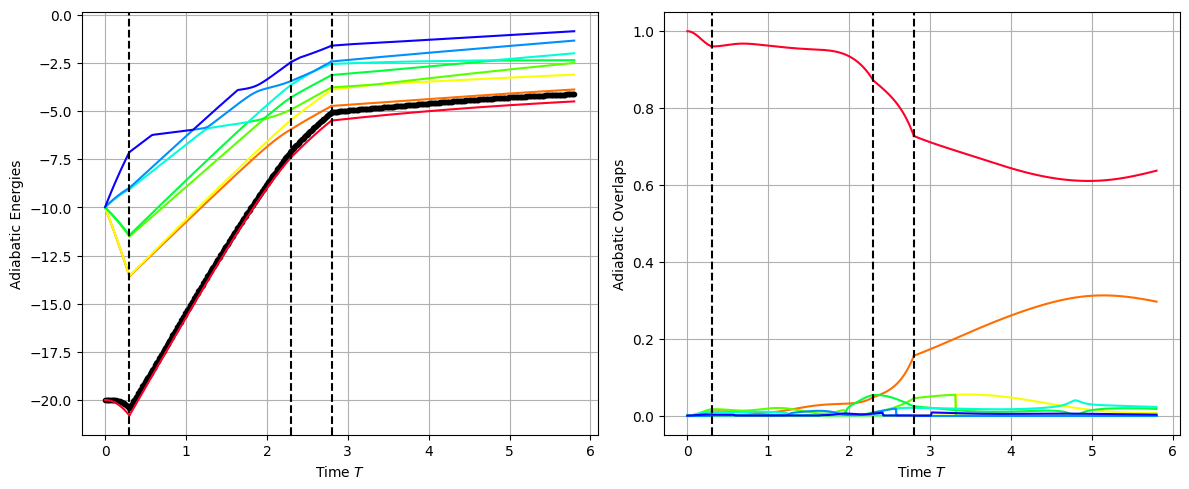

In [9]:
def plot_adiabatic_path(Js, mus, Vs, t_durations, N, M, J_V_ratio_grid, mu_grid, one_over_energy_gap_grid, colors, n_excited_states):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)

    total_time = sum(t_durations)
    cumulative_time = 0

    for i in range(len(Js) - 1):
        t_total_step = t_durations[i]
        
        # Interpolate parameters for each step
        mu_array = interpolate_parameters(mus[i], mus[i+1], t_total_step, method="linear")
        J_array = interpolate_parameters(Js[i], Js[i+1], t_total_step, method="linear")
        V_array = interpolate_parameters(Vs[i], Vs[i+1], t_total_step, method="linear")
        J_V_ratio_array = J_array / V_array

        # Perform adiabatic simulation
        if i == 0:
            results = calculate_adiabatic_properties(N=N, M=M, init_mu=mus[i], init_J=Js[i], init_V=Vs[i], final_mu=mus[i+1], final_J=Js[i+1], final_V=Vs[i+1], t_total=t_total_step, dt=0.01, initial_state=None)
        else:
            results = calculate_adiabatic_properties(N=N, M=M, init_mu=mus[i], init_J=Js[i], init_V=Vs[i], final_mu=mus[i+1], final_J=Js[i+1], final_V=Vs[i+1], t_total=t_total_step, dt=0.01, initial_state=adiabatic_wavefunctions[-1])

        adiabatic_energies, adiabatic_diff, adiabatic_wavefunctions, adiabatic_overlaps, true_energies, energy_gaps, times = results

        # Plot each step
        ax1.plot(cumulative_time + times, adiabatic_energies, color="black", marker=".", linestyle="", label=f"Step {i+1}: $\\Psi^\\dagger(t) H \\Psi(t)$")
        for j in range(n_excited_states):
            ax1.plot(cumulative_time + times, true_energies[:, j], color=colors[j], label=f"Step {i+1}: $E_{{j}}$")
        
        if i != 0:
            ax1.axvline(cumulative_time, color="k", linestyle="--")
        
        for j in range(n_excited_states):
            ax2.plot(cumulative_time + times, adiabatic_overlaps[:, j], color=colors[j])
        
        if i != 0:
            ax2.axvline(cumulative_time, color="k", linestyle="--")
        
        cumulative_time += t_total_step

    ax1.set_xlabel("Time $T$")
    ax1.set_ylabel("Adiabatic Energies")
    ax1.grid(True)

    ax2.set_xlabel("Time $T$")
    ax2.set_ylabel("Adiabatic Overlaps")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
Js = [0.01, 2, 1.5, 1.25, 1]
mus = [10, 10, 2.5, 1.25, 0]
Vs = [-0.01, -0.1, -1.5, -1.5, -2]
t_durations = [0.3, 2, 0.5, 3]

plot_adiabatic_path(Js, mus, Vs, t_durations, N, M, J_V_ratio_grid, mu_grid, one_over_energy_gap_grid, colors, n_excited_states)

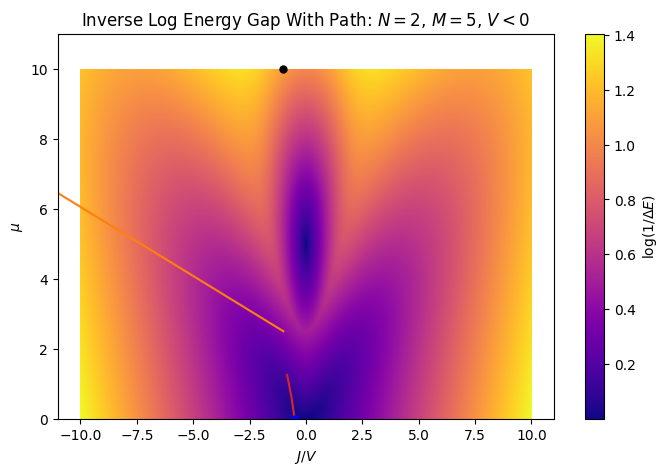

In [ ]:
# has major errors, need to fix
def plot_adiabatic_curve(Js, mus, Vs, t_durations, N, M, J_V_ratio_grid, mu_grid, one_over_energy_gap_grid):
    plt.figure(figsize=(8, 5))

    for i in range(len(Js) - 1):
        t_total_step = t_durations[i]
        
        # Interpolate parameters for each step
        mu_array = interpolate_parameters(mus[i], mus[i+1], t_total_step, method="linear")
        J_array = interpolate_parameters(Js[i], Js[i+1], t_total_step, method="linear")
        V_array = interpolate_parameters(Vs[i], Vs[i+1], t_total_step, method="linear")
        J_V_ratio_array = J_array / V_array

        # Plot the interpolated path
        plt.plot(J_V_ratio_array, mu_array, linestyle='-', markersize=1, label=f'Path {i+1}')

    plt.plot(Js[0] / Vs[0], mus[0], 'ko', markersize=5, label=f'$(\\mu, J, V) = ({mus[0]}, {Js[0]}, {Vs[0]})$')
    plt.plot(Js[-1] / Vs[-1], mus[-1], 'bo', markersize=5, label=f'$(\\mu, J, V) = ({mus[-1]}, {Js[-1]}, {Vs[-1]})$')

    plt.pcolormesh(J_V_ratio_grid, mu_grid, 1/one_over_energy_gap_grid, shading='auto', cmap='plasma')
    #plt.colorbar(label="$\\log(1/\\Delta E)$") not log 1/gap
    plt.xlabel("$J/V$")
    plt.ylabel("$\\mu$")
    plt.title(f"Inverse Log Energy Gap With Path: $N={N}$, $M={M}$, $V<0$")
    plt.xlim(-11,11)
    plt.ylim(0, 11)
    #lt.legend()
    #plt.show()

# Example usage
Js = [0.01, 2, 1.5, 1.25, 1]
mus = [10, 10, 2.5, 1.25, 0]
Vs = [-0.01, -0.1, -1.5, -1.5, -2]
t_durations = [0.3, 2, 0.5, 3]

plot_adiabatic_curve(Js, mus, Vs, t_durations, N, M, J_V_ratio_grid, mu_grid, one_over_energy_gap_grid)